In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

ROOT = "/content/drive/MyDrive/Colab Notebooks/DM/HW/논문참조_data"

# 1. CBR (사례기반 추론)

## Nearest Neighbor (근접이웃방법론)

## Case 1: categorical target (classification)

### Step 1. Dataset preprocessing

In [49]:
df = pd.read_csv(f"{ROOT}/movies_metadata.csv")

<ipython-input-49-daf2adbe1451>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{ROOT}/movies_metadata.csv")


In [50]:
df.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [51]:
df.drop(["belongs_to_collection","homepage","tagline","overview","poster_path","imdb_id","original_language"], axis=1,inplace=True)

In [52]:
# popularity 형변환
df["popularity"].fillna(value=df["popularity"].mode(),inplace=True)
df["popularity"] = pd.to_numeric(df["popularity"],errors ='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 45466 non-null  object 
 1   budget                45466 non-null  object 
 2   genres                45466 non-null  object 
 3   id                    45466 non-null  object 
 4   original_title        45466 non-null  object 
 5   popularity            45460 non-null  float64
 6   production_companies  45463 non-null  object 
 7   production_countries  45463 non-null  object 
 8   release_date          45379 non-null  object 
 9   revenue               45460 non-null  float64
 10  runtime               45203 non-null  float64
 11  spoken_languages      45460 non-null  object 
 12  status                45379 non-null  object 
 13  title                 45460 non-null  object 
 14  video                 45460 non-null  object 
 15  vote_average       

In [53]:
# 결측치 처리
df["release_date"].fillna("2008-01-01",inplace=True)
df["revenue"].fillna(df["revenue"].mean(),inplace=True)
df["runtime"].fillna(df["runtime"].mean(),inplace=True)
df["status"].fillna("Released",inplace=True)
df["video"].fillna("False",inplace=True)
df["popularity"].fillna(df["popularity"].mean(),inplace=True)
df["vote_average"].fillna(df["vote_average"].mean(),inplace=True)
df["vote_count"].fillna(df["vote_count"].mean(),inplace=True)

print(df.isnull().sum())

adult                   0
budget                  0
genres                  0
id                      0
original_title          0
popularity              0
production_companies    3
production_countries    3
release_date            0
revenue                 0
runtime                 0
spoken_languages        6
status                  0
title                   6
video                   0
vote_average            0
vote_count              0
dtype: int64


In [54]:
df["popularity"].mean()

2.92147834491861

In [55]:
# popularity categorical data로 변환 : mean(popularity) 보다 크면 1, 작으면 0
def label_encoder(row):
    if row["popularity"] > 2.92:
        return 1
    else:
        return 0

In [56]:
df["label"] = df.apply(lambda row: label_encoder(row), axis=1)
df.head(5)

,adult,budget,genres,id,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count,label
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7,5415.0,1
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,False,6.9,2413.0,1
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,False,6.5,92.0,1
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale,3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,False,6.1,34.0,1
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,False,5.7,173.0,1


In [57]:
# 불필요 데이터 drop
df.drop(["id","genres","spoken_languages","title","original_title","production_companies","production_countries"],axis=1,inplace=True)
df.head(3)

,adult,budget,popularity,release_date,revenue,runtime,status,video,vote_average,vote_count,label
0,False,30000000,21.946943,1995-10-30,373554033.0,81.0,Released,False,7.7,5415.0,1
1,False,65000000,17.015539,1995-12-15,262797249.0,104.0,Released,False,6.9,2413.0,1
2,False,0,11.712900,1995-12-22,0.0,101.0,Released,False,6.5,92.0,1


In [58]:
# 날짜 데이터 year와 month로 분리
df["release_year"] = df["release_date"].apply(lambda x : int(x[:4]))
df["release_month"] = df["release_date"].apply(lambda x : x[5:7])
df = df[df["release_month"]!= ""]
df["release_month"] = df["release_month"].apply(lambda x : int(x))
df.drop("release_date",axis=1,inplace=True)

# budget 데이터 형변환
df["budget"] = df["budget"].apply(lambda x: float(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45463 entries, 0 to 45465
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   adult          45463 non-null  object 
 1   budget         45463 non-null  float64
 2   popularity     45463 non-null  float64
 3   revenue        45463 non-null  float64
 4   runtime        45463 non-null  float64
 5   status         45463 non-null  object 
 6   video          45463 non-null  object 
 7   vote_average   45463 non-null  float64
 8   vote_count     45463 non-null  float64
 9   label          45463 non-null  int64  
 10  release_year   45463 non-null  int64  
 11  release_month  45463 non-null  int64  
dtypes: float64(6), int64(3), object(3)
memory usage: 4.5+ MB


<ipython-input-58-eef3b2b9fd3e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["release_month"] = df["release_month"].apply(lambda x : int(x))
<ipython-input-58-eef3b2b9fd3e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("release_date",axis=1,inplace=True)
<ipython-input-58-eef3b2b9fd3e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [59]:
for i in df.select_dtypes("object").columns:
    print(f"Column {i} has these type of data: {df[i].nunique()}")
    print("***************************************************")

Column adult has these type of data: 2
***************************************************
Column status has these type of data: 6
***************************************************
Column video has these type of data: 3
***************************************************


In [60]:
print("video : ", df["video"].unique())
print("adult : ", df["adult"].unique())
print("status : ", df["status"].unique())

video :  [False True 'False']
adult :  ['False' 'True']
status :  ['Released' 'Rumored' 'Post Production' 'In Production' 'Planned'
 'Canceled']


In [61]:
# video, adult : False = 0, True = 1로 변환
df["video"].replace('False', False, inplace = True)
df["video"].replace({False : 0, True : 1}, inplace = True)
df["adult"].replace({'False' : 0, 'True' : 1}, inplace = True)

# status : get_dummies로 더미 변수화
df_transformed = pd.get_dummies(df, columns=["status"])
df_transformed

<ipython-input-61-a26367306f0d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["video"].replace('False', False, inplace = True)


,adult,budget,popularity,revenue,runtime,video,vote_average,vote_count,label,release_year,release_month,status_Canceled,status_In Production,status_Planned,status_Post Production,status_Released,status_Rumored
0,0,30000000.0,21.946943,373554033.0,81.0,0,7.7,5415.0,1,1995,10,0,0,0,0,1,0
1,0,65000000.0,17.015539,262797249.0,104.0,0,6.9,2413.0,1,1995,12,0,0,0,0,1,0
2,0,0.0,11.712900,0.0,101.0,0,6.5,92.0,1,1995,12,0,0,0,0,1,0
3,0,16000000.0,3.859495,81452156.0,127.0,0,6.1,34.0,1,1995,12,0,0,0,0,1,0
4,0,0.0,8.387519,76578911.0,106.0,0,5.7,173.0,1,1995,2,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,0,0.0,0.072051,0.0,90.0,0,4.0,1.0,0,2008,1,0,0,0,0,1,0
45462,0,0.0,0.178241,0.0,360.0,0,9.0,3.0,0,2011,11,0,0,0,0,1,0
45463,0,0.0,0.903007,0.0,90.0,0,3.8,6.0,0,2003,8,0,0,0,0,1,0
45464,0,0.0,0.003503,0.0,87.0,0,0.0,0.0,0,1917,10,0,0,0,0,1,0


In [62]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45463 entries, 0 to 45465
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   adult                   45463 non-null  int64  
 1   budget                  45463 non-null  float64
 2   popularity              45463 non-null  float64
 3   revenue                 45463 non-null  float64
 4   runtime                 45463 non-null  float64
 5   video                   45463 non-null  int64  
 6   vote_average            45463 non-null  float64
 7   vote_count              45463 non-null  float64
 8   label                   45463 non-null  int64  
 9   release_year            45463 non-null  int64  
 10  release_month           45463 non-null  int64  
 11  status_Canceled         45463 non-null  uint8  
 12  status_In Production    45463 non-null  uint8  
 13  status_Planned          45463 non-null  uint8  
 14  status_Post Production  45463 non-null

In [63]:
# x와 y 분리
x = df_transformed.drop("label",axis=1)
y = df_transformed["label"]

In [64]:
x.head()

,adult,budget,popularity,revenue,runtime,video,vote_average,vote_count,release_year,release_month,status_Canceled,status_In Production,status_Planned,status_Post Production,status_Released,status_Rumored
0,0,30000000.0,21.946943,373554033.0,81.0,0,7.7,5415.0,1995,10,0,0,0,0,1,0
1,0,65000000.0,17.015539,262797249.0,104.0,0,6.9,2413.0,1995,12,0,0,0,0,1,0
2,0,0.0,11.712900,0.0,101.0,0,6.5,92.0,1995,12,0,0,0,0,1,0
3,0,16000000.0,3.859495,81452156.0,127.0,0,6.1,34.0,1995,12,0,0,0,0,1,0
4,0,0.0,8.387519,76578911.0,106.0,0,5.7,173.0,1995,2,0,0,0,0,1,0


In [65]:
print(y.value_counts())

0    32385
1    13078
Name: label, dtype: int64


In [66]:
x.describe() # 독립변수(feature)의 기초통계량

,adult,budget,popularity,revenue,runtime,video,vote_average,vote_count,release_year,release_month,status_Canceled,status_In Production,status_Planned,status_Post Production,status_Released,status_Rumored
count,45463.000000,4.546300e+04,45463.000000,4.546300e+04,45463.000000,45463.000000,45463.000000,45463.000000,45463.000000,45463.000000,45463.000000,45463.00000,45463.000000,45463.000000,45463.000000,45463.000000
mean,0.000198,4.224579e+06,2.921478,1.120935e+07,94.128199,0.002046,5.618207,109.897338,1991.912038,6.448629,0.000044,0.00044,0.000330,0.002156,0.991971,0.005059
std,0.014069,1.742413e+07,6.005216,6.433012e+07,38.297825,0.045183,1.924153,491.294163,24.042654,3.632531,0.006633,0.02097,0.018161,0.046379,0.089243,0.070948
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1874.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.386012,0.000000e+00,85.000000,0.000000,5.000000,3.000000,1978.000000,3.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000e+00,1.127808,0.000000e+00,95.000000,0.000000,6.000000,10.000000,2001.000000,7.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000e+00,3.678588,0.000000e+00,107.000000,0.000000,6.800000,34.000000,2010.000000,10.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000
max,1.000000,3.800000e+08,547.488298,2.787965e+09,1256.000000,1.000000,10.000000,14075.000000,2020.000000,12.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


- 관측치들 간 유사성을 측정할 때 변수의 크기에 영향을 받지 않도록 scaling 진행 ([예시](https://stats.stackexchange.com/questions/287425/why-do-you-need-to-scale-data-in-knn))

In [67]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45463 entries, 0 to 45465
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   adult                   45463 non-null  int64  
 1   budget                  45463 non-null  float64
 2   popularity              45463 non-null  float64
 3   revenue                 45463 non-null  float64
 4   runtime                 45463 non-null  float64
 5   video                   45463 non-null  int64  
 6   vote_average            45463 non-null  float64
 7   vote_count              45463 non-null  float64
 8   release_year            45463 non-null  int64  
 9   release_month           45463 non-null  int64  
 10  status_Canceled         45463 non-null  uint8  
 11  status_In Production    45463 non-null  uint8  
 12  status_Planned          45463 non-null  uint8  
 13  status_Post Production  45463 non-null  uint8  
 14  status_Released         45463 non-null

In [68]:
# 범주형 변수를 제외한 열을 선택
numeric_cols = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'release_year', 'release_month']

# 범주형 변수를 제외한 열만을 스케일링
# Z-score Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_x = pd.DataFrame(scaler.fit_transform(x[numeric_cols]), columns=numeric_cols, index=x.index)

scaled_x = pd.concat([scaled_x, x.drop(numeric_cols, axis=1)], axis=1)
scaled_x = scaled_x[x.columns]
scaled_x.head()


,adult,budget,popularity,revenue,runtime,video,vote_average,vote_count,release_year,release_month,status_Canceled,status_In Production,status_Planned,status_Post Production,status_Released,status_Rumored
0,0,1.479311,3.168191,5.632644,-0.342796,0,1.081939,10.798339,0.128438,0.977668,0,0,0,0,1,0
1,0,3.488041,2.346996,3.910931,0.257767,0,0.666167,4.687880,0.128438,1.528255,0,0,0,0,1,0
2,0,-0.242458,1.463980,-0.174249,0.179433,0,0.458281,-0.036429,0.128438,1.528255,0,0,0,0,1,0
3,0,0.675818,0.156202,1.091924,0.858330,0,0.250395,-0.154486,0.128438,1.528255,0,0,0,0,1,0
4,0,-0.242458,0.910225,1.016169,0.309990,0,0.042509,0.128443,0.128438,-1.224677,0,0,0,0,1,0


In [69]:
scaled_x.describe() # 표준화 이후, 독립변수(feature)의 기초통계량

,adult,budget,popularity,revenue,runtime,video,vote_average,vote_count,release_year,release_month,status_Canceled,status_In Production,status_Planned,status_Post Production,status_Released,status_Rumored
count,45463.000000,4.546300e+04,4.546300e+04,4.546300e+04,4.546300e+04,45463.000000,4.546300e+04,4.546300e+04,4.546300e+04,4.546300e+04,45463.000000,45463.00000,45463.000000,45463.000000,45463.000000,45463.000000
mean,0.000198,4.251097e-17,1.750452e-17,1.875484e-17,3.300852e-16,0.002046,-1.500387e-16,-1.500387e-17,-1.970509e-15,-1.350348e-16,0.000044,0.00044,0.000330,0.002156,0.991971,0.005059
std,0.014069,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,0.045183,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,0.006633,0.02097,0.018161,0.046379,0.089243,0.070948
min,0.000000,-2.424583e-01,-4.864955e-01,-1.742492e-01,-2.457822e+00,0.000000,-2.919867e+00,-2.236919e-01,-4.904339e+00,-1.499970e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-2.424583e-01,-4.222152e-01,-1.742492e-01,-2.383503e-01,0.000000,-3.212916e-01,-2.175856e-01,-5.786462e-01,-9.493840e-01,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,-2.424583e-01,-2.986887e-01,-1.742492e-01,2.276396e-02,0.000000,1.984235e-01,-2.033373e-01,3.779974e-01,1.517888e-01,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,-2.424583e-01,1.260767e-01,-1.742492e-01,3.361011e-01,0.000000,6.141955e-01,-1.544862e-01,7.523363e-01,9.776684e-01,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000
max,1.000000,2.156661e+01,9.068330e+01,4.316463e+01,3.033814e+01,1.000000,2.277284e+00,2.842545e+01,1.168268e+00,1.528255e+00,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


### Step 2. Train test split
- 적절한 k값 선택을 위해 train, valid, test set으로 구분

In [70]:
# train,test,valid 분할 과정에서 y 값의 분포 유지 위해 stratify 사용
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size = 0.2, random_state = 312, stratify=y)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = 312, stratify=y_train)

In [71]:
print("train set:",x_train.shape)
print("valid set:",x_valid.shape)
print("test set:",x_test.shape)

train set: (29096, 16)
valid set: (7274, 16)
test set: (9093, 16)


In [72]:
#y 값 분포
y_train.value_counts()

0    20726
1     8370
Name: label, dtype: int64

### Step 3. Sampling
- 본 실습에서는 랜덤 언더 샘플링을 진행하여 비중을 맞춰주고자 함

In [73]:
X_resampled, y_resampled = RandomUnderSampler(random_state=312, sampling_strategy='majority').fit_resample(x_train, y_train)

랜덤 언더 샘플링을 통해 y 분포가 동일함을 확인함

In [74]:
print(y_resampled.value_counts())

0    8370
1    8370
Name: label, dtype: int64


### Step 4. KNN classification

#### weights 선정 - distance

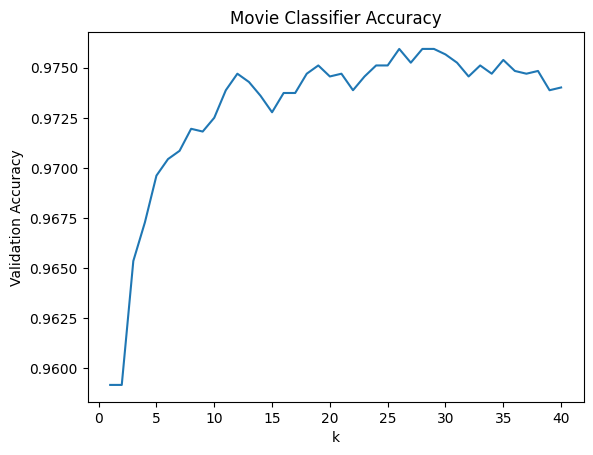

In [75]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

'''
k를 변화시켜가며 더 적합한 k를 찾기 위해 plot을 통해 accuracy를 확인
'''

k_list = range(1,41) # k= 1~40까지 조절
accuracies = []
best_k = 0
best_acc = 0
for k in k_list:
    classifier = KNeighborsClassifier(n_neighbors = k, weights="distance", metric="euclidean")
    classifier.fit(X_resampled, y_resampled)
    acc = classifier.score(x_valid, y_valid)
    accuracies.append(acc)
    if best_acc < acc:
        best_acc = acc
        best_k = k
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Movie Classifier Accuracy")
plt.show()

In [76]:
classifier = KNeighborsClassifier(n_neighbors = best_k, weights="distance", metric="euclidean")
classifier.fit(X_resampled, y_resampled)

KNeighborsClassifier(metric='euclidean', n_neighbors=26, weights='distance')

In [77]:
print(classifier.score(x_test, y_test)) # accuracy

0.9781150335422852


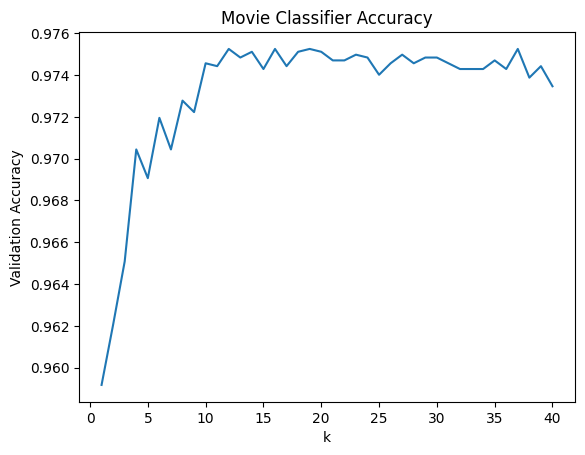

In [78]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

'''
k를 변화시켜가며 더 적합한 k를 찾기 위해 plot을 통해 accuracy를 확인
'''

k_list = range(1,41) # k= 1~40까지 조절
accuracies = []
best_k = 0
best_acc = 0
for k in k_list:
    classifier = KNeighborsClassifier(n_neighbors = k, weights="uniform", metric="euclidean")
    classifier.fit(X_resampled, y_resampled)
    acc = classifier.score(x_valid, y_valid)
    accuracies.append(acc)
    if best_acc < acc:
        best_acc = acc
        best_k = k
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Movie Classifier Accuracy")
plt.show()

In [79]:
classifier = KNeighborsClassifier(n_neighbors = best_k, weights="uniform", metric="euclidean")
classifier.fit(X_resampled, y_resampled)

KNeighborsClassifier(metric='euclidean', n_neighbors=12)

In [80]:
print(classifier.score(x_test, y_test)) # accuracy

0.976575387660838


#### algorithm 선정 - auto

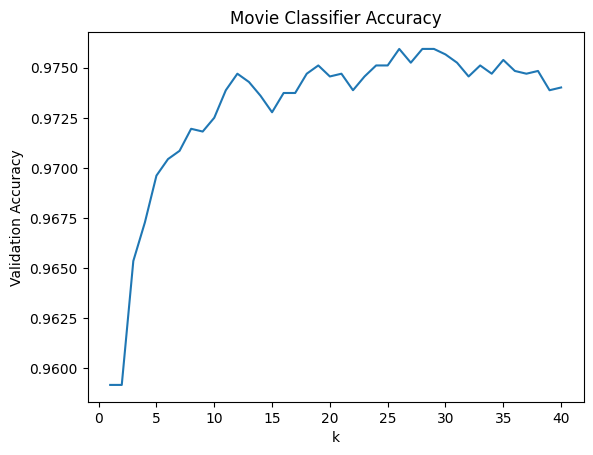

In [81]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

'''
k를 변화시켜가며 더 적합한 k를 찾기 위해 plot을 통해 accuracy를 확인
'''

k_list = range(1,41) # k= 1~40까지 조절
accuracies = []
best_k = 0
best_acc = 0
for k in k_list:
    classifier = KNeighborsClassifier(n_neighbors = k, weights="distance", metric="euclidean", algorithm = 'ball_tree')
    classifier.fit(X_resampled, y_resampled)
    acc = classifier.score(x_valid, y_valid)
    accuracies.append(acc)
    if best_acc < acc:
        best_acc = acc
        best_k = k
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Movie Classifier Accuracy")
plt.show()

In [82]:
classifier = KNeighborsClassifier(n_neighbors = best_k, weights="distance", metric="euclidean", algorithm = 'ball_tree')
classifier.fit(X_resampled, y_resampled)

KNeighborsClassifier(algorithm='ball_tree', metric='euclidean', n_neighbors=26,
                     weights='distance')

In [83]:
print(classifier.score(x_test, y_test)) # accuracy

0.9781150335422852


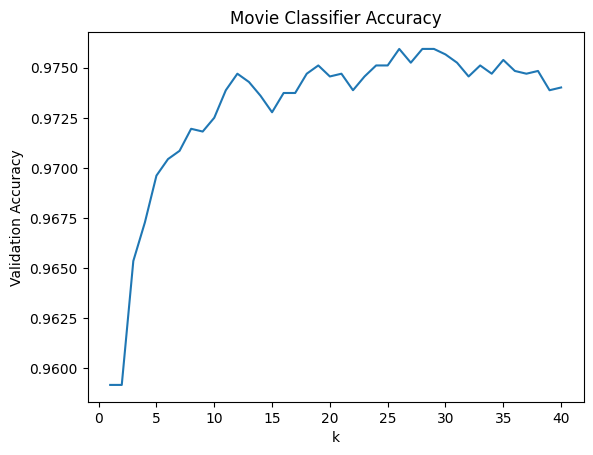

In [84]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

'''
k를 변화시켜가며 더 적합한 k를 찾기 위해 plot을 통해 accuracy를 확인
'''

k_list = range(1,41) # k= 1~40까지 조절
accuracies = []
best_k = 0
best_acc = 0
for k in k_list:
    classifier = KNeighborsClassifier(n_neighbors = k, weights="distance", metric="euclidean", algorithm = 'kd_tree')
    classifier.fit(X_resampled, y_resampled)
    acc = classifier.score(x_valid, y_valid)
    accuracies.append(acc)
    if best_acc < acc:
        best_acc = acc
        best_k = k
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Movie Classifier Accuracy")
plt.show()

In [85]:
classifier = KNeighborsClassifier(n_neighbors = best_k, weights="distance", metric="euclidean", algorithm = 'kd_tree')
classifier.fit(X_resampled, y_resampled)

KNeighborsClassifier(algorithm='kd_tree', metric='euclidean', n_neighbors=26,
                     weights='distance')

In [86]:
print(classifier.score(x_test, y_test)) # accuracy

0.9781150335422852


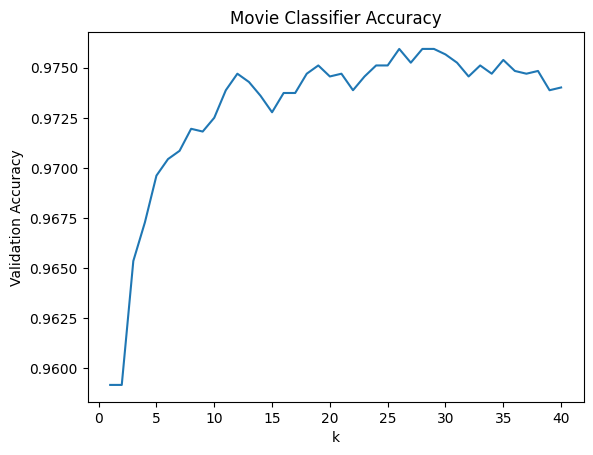

In [87]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

'''
k를 변화시켜가며 더 적합한 k를 찾기 위해 plot을 통해 accuracy를 확인
'''

k_list = range(1,41) # k= 1~40까지 조절
accuracies = []
best_k = 0
best_acc = 0
for k in k_list:
    classifier = KNeighborsClassifier(n_neighbors = k, weights="distance", metric="euclidean", algorithm = 'brute')
    classifier.fit(X_resampled, y_resampled)
    acc = classifier.score(x_valid, y_valid)
    accuracies.append(acc)
    if best_acc < acc:
        best_acc = acc
        best_k = k
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Movie Classifier Accuracy")
plt.show()

In [88]:
classifier = KNeighborsClassifier(n_neighbors = best_k, weights="distance", metric="euclidean", algorithm = 'brute')
classifier.fit(X_resampled, y_resampled)

KNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=26,
                     weights='distance')

In [89]:
print(classifier.score(x_test, y_test)) # accuracy

0.9781150335422852


#### metric 선정 - manhattan

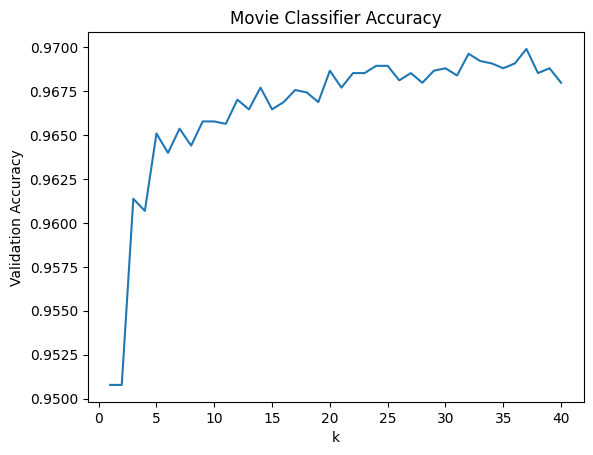

In [90]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

'''
k를 변화시켜가며 더 적합한 k를 찾기 위해 plot을 통해 accuracy를 확인
'''

k_list = range(1,41) # k= 1~40까지 조절
accuracies = []
best_k = 0
best_acc = 0
for k in k_list:
    classifier = KNeighborsClassifier(n_neighbors = k, weights="distance", metric="chebyshev")
    classifier.fit(X_resampled, y_resampled)
    acc = classifier.score(x_valid, y_valid)
    accuracies.append(acc)
    if best_acc < acc:
        best_acc = acc
        best_k = k
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Movie Classifier Accuracy")
plt.show()

In [91]:
classifier = KNeighborsClassifier(n_neighbors = best_k, weights="distance", metric="chebyshev")
classifier.fit(X_resampled, y_resampled)

KNeighborsClassifier(metric='chebyshev', n_neighbors=37, weights='distance')

In [92]:
print(classifier.score(x_test, y_test)) # accuracy

0.9712966017815903


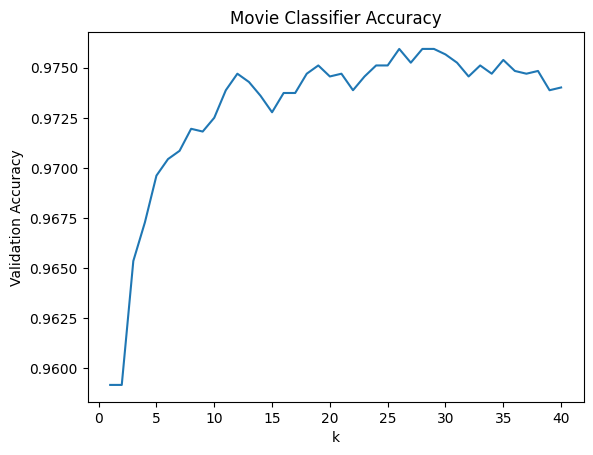

In [93]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

'''
k를 변화시켜가며 더 적합한 k를 찾기 위해 plot을 통해 accuracy를 확인
'''

k_list = range(1,41) # k= 1~40까지 조절
accuracies = []
best_k = 0
best_acc = 0
for k in k_list:
    classifier = KNeighborsClassifier(n_neighbors = k, weights="distance", metric="minkowski")
    classifier.fit(X_resampled, y_resampled)
    acc = classifier.score(x_valid, y_valid)
    accuracies.append(acc)
    if best_acc < acc:
        best_acc = acc
        best_k = k
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Movie Classifier Accuracy")
plt.show()

In [94]:
classifier = KNeighborsClassifier(n_neighbors = best_k, weights="distance", metric="minkowski")
classifier.fit(X_resampled, y_resampled)

KNeighborsClassifier(n_neighbors=26, weights='distance')

In [95]:
print(classifier.score(x_test, y_test)) # accuracy

0.9781150335422852


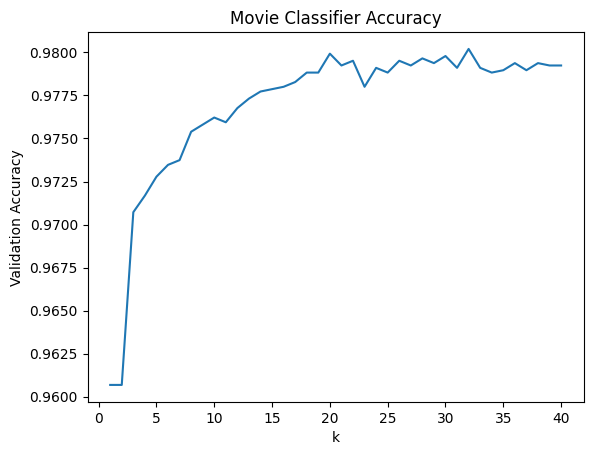

In [96]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

'''
k를 변화시켜가며 더 적합한 k를 찾기 위해 plot을 통해 accuracy를 확인
'''

k_list = range(1,41) # k= 1~40까지 조절
accuracies = []
best_k = 0
best_acc = 0
for k in k_list:
    classifier = KNeighborsClassifier(n_neighbors = k, weights="distance", metric="manhattan")
    classifier.fit(X_resampled, y_resampled)
    acc = classifier.score(x_valid, y_valid)
    accuracies.append(acc)
    if best_acc < acc:
        best_acc = acc
        best_k = k
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Movie Classifier Accuracy")
plt.show()

In [97]:
classifier = KNeighborsClassifier(n_neighbors = best_k, weights="distance", metric="manhattan")
classifier.fit(X_resampled, y_resampled)

KNeighborsClassifier(metric='manhattan', n_neighbors=32, weights='distance')

In [98]:
print(classifier.score(x_test, y_test)) # accuracy

0.984053667656439


### Step 5. Evaluation

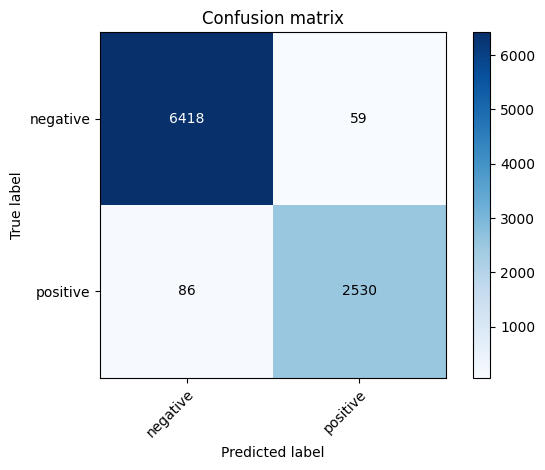

In [99]:
y_pred = classifier.predict(x_test) # 분류 모델
cm = confusion_matrix(y_test, y_pred) # 예측 데이터와 예측값의 정답(y_true)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues) # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['negative', 'positive'], # 표에 표시할 labels
       yticklabels=['negative', 'positive'], # 표에 표시할 labels
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center", 
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()


In [100]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(" Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("   Recall:", recall_score(y_test, y_pred))
print(" F1 score:", f1_score(y_test, y_pred))

 Accuracy: 0.984053667656439
Precision: 0.977211278485902
   Recall: 0.9671253822629969
 F1 score: 0.9721421709894332


## Case 2: continuous target (regression)

### Step 1. Dataset preprocessing

In [101]:
df = df_transformed.drop(['label'], axis = 1)
df.head()

,adult,budget,popularity,revenue,runtime,video,vote_average,vote_count,release_year,release_month,status_Canceled,status_In Production,status_Planned,status_Post Production,status_Released,status_Rumored
0,0,30000000.0,21.946943,373554033.0,81.0,0,7.7,5415.0,1995,10,0,0,0,0,1,0
1,0,65000000.0,17.015539,262797249.0,104.0,0,6.9,2413.0,1995,12,0,0,0,0,1,0
2,0,0.0,11.712900,0.0,101.0,0,6.5,92.0,1995,12,0,0,0,0,1,0
3,0,16000000.0,3.859495,81452156.0,127.0,0,6.1,34.0,1995,12,0,0,0,0,1,0
4,0,0.0,8.387519,76578911.0,106.0,0,5.7,173.0,1995,2,0,0,0,0,1,0


In [102]:
y = df[["vote_average"]]
x = df.drop(['vote_average'],axis=1)

In [103]:
# 범주형 변수를 제외한 열을 선택
numeric_cols = ['budget', 'popularity', 'revenue', 'runtime', 'vote_count', 'release_year', 'release_month']

# 범주형 변수를 제외한 열만을 스케일링
# Z-score Standardization
scaler = StandardScaler()
scaled_x = pd.DataFrame(scaler.fit_transform(x[numeric_cols]), columns=numeric_cols, index=x.index)

scaled_x = pd.concat([scaled_x, x.drop(numeric_cols, axis=1)], axis=1)
scaled_x = scaled_x[x.columns]
scaled_x.head()

,adult,budget,popularity,revenue,runtime,video,vote_count,release_year,release_month,status_Canceled,status_In Production,status_Planned,status_Post Production,status_Released,status_Rumored
0,0,1.479311,3.168191,5.632644,-0.342796,0,10.798339,0.128438,0.977668,0,0,0,0,1,0
1,0,3.488041,2.346996,3.910931,0.257767,0,4.687880,0.128438,1.528255,0,0,0,0,1,0
2,0,-0.242458,1.463980,-0.174249,0.179433,0,-0.036429,0.128438,1.528255,0,0,0,0,1,0
3,0,0.675818,0.156202,1.091924,0.858330,0,-0.154486,0.128438,1.528255,0,0,0,0,1,0
4,0,-0.242458,0.910225,1.016169,0.309990,0,0.128443,0.128438,-1.224677,0,0,0,0,1,0


In [104]:
x_std = scaled_x
x_std.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45463 entries, 0 to 45465
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   adult                   45463 non-null  int64  
 1   budget                  45463 non-null  float64
 2   popularity              45463 non-null  float64
 3   revenue                 45463 non-null  float64
 4   runtime                 45463 non-null  float64
 5   video                   45463 non-null  int64  
 6   vote_count              45463 non-null  float64
 7   release_year            45463 non-null  float64
 8   release_month           45463 non-null  float64
 9   status_Canceled         45463 non-null  uint8  
 10  status_In Production    45463 non-null  uint8  
 11  status_Planned          45463 non-null  uint8  
 12  status_Post Production  45463 non-null  uint8  
 13  status_Released         45463 non-null  uint8  
 14  status_Rumored          45463 non-null

In [105]:
x_std.describe()

,adult,budget,popularity,revenue,runtime,video,vote_count,release_year,release_month,status_Canceled,status_In Production,status_Planned,status_Post Production,status_Released,status_Rumored
count,45463.000000,4.546300e+04,4.546300e+04,4.546300e+04,4.546300e+04,45463.000000,4.546300e+04,4.546300e+04,4.546300e+04,45463.000000,45463.00000,45463.000000,45463.000000,45463.000000,45463.000000
mean,0.000198,4.251097e-17,1.750452e-17,1.875484e-17,3.300852e-16,0.002046,-1.500387e-17,-1.970509e-15,-1.350348e-16,0.000044,0.00044,0.000330,0.002156,0.991971,0.005059
std,0.014069,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,0.045183,1.000011e+00,1.000011e+00,1.000011e+00,0.006633,0.02097,0.018161,0.046379,0.089243,0.070948
min,0.000000,-2.424583e-01,-4.864955e-01,-1.742492e-01,-2.457822e+00,0.000000,-2.236919e-01,-4.904339e+00,-1.499970e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-2.424583e-01,-4.222152e-01,-1.742492e-01,-2.383503e-01,0.000000,-2.175856e-01,-5.786462e-01,-9.493840e-01,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,-2.424583e-01,-2.986887e-01,-1.742492e-01,2.276396e-02,0.000000,-2.033373e-01,3.779974e-01,1.517888e-01,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,-2.424583e-01,1.260767e-01,-1.742492e-01,3.361011e-01,0.000000,-1.544862e-01,7.523363e-01,9.776684e-01,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000
max,1.000000,2.156661e+01,9.068330e+01,4.316463e+01,3.033814e+01,1.000000,2.842545e+01,1.168268e+00,1.528255e+00,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


### Step 2. Train test split

0404 수업
- 연속형이라서 undersampling / stratify 안하고 바로 진행

In [106]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size = 0.2, random_state = 312)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = 312)

In [107]:
print("train set:",x_train.shape)
print("valid set:",x_valid.shape)
print("test set:",x_test.shape)

train set: (29096, 15)
valid set: (7274, 15)
test set: (9093, 15)


### Step 3. KNN regression

#### weights 선정 - distance

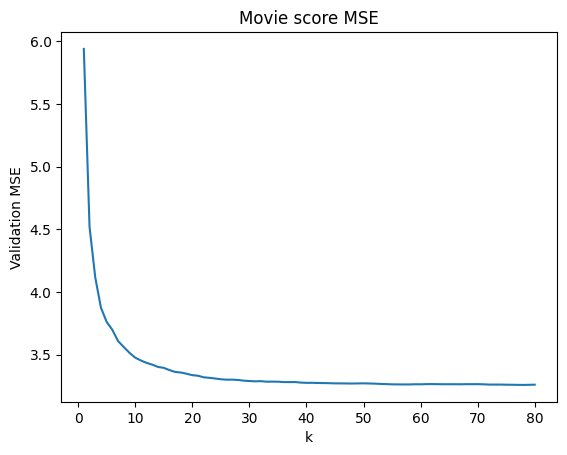

In [108]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

'''
k를 변화시켜가며 더 적합한 k를 찾기 위해 plot을 통해 accuracy를 확인
'''

best_mse = 1000000000
k_list = range(1,81) # k= 1~80까지 조절
mses = []
for k in k_list:
  regressor_k = KNeighborsRegressor(n_neighbors = k, weights="distance", metric="euclidean")
  regressor_k.fit(x_train, y_train)
  mse = mean_squared_error(y_valid, regressor_k.predict(x_valid))
  mses.append(mse)
  if best_mse > mse:
    best_mse = mse
    best_k = k
plt.plot(k_list, mses)
plt.xlabel("k")
plt.ylabel("Validation MSE")
plt.title("Movie score MSE")
plt.show()

In [109]:
regressor = KNeighborsRegressor(n_neighbors = best_k, weights="distance", metric="euclidean")

In [110]:
regressor.fit(x_train, y_train)

KNeighborsRegressor(metric='euclidean', n_neighbors=78, weights='distance')

In [111]:
pred_y = regressor.predict(x_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print("MSE :", mean_squared_error(y_test, pred_y))
print("RMSE:", mean_squared_error(y_test, pred_y, squared=False))
print("MAE :", mean_absolute_error(y_test, pred_y))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_y))

MSE : 3.1500569117149246
RMSE: 1.7748399679168048
MAE : 1.2320382270448988
MAPE: 1376677374779961.5


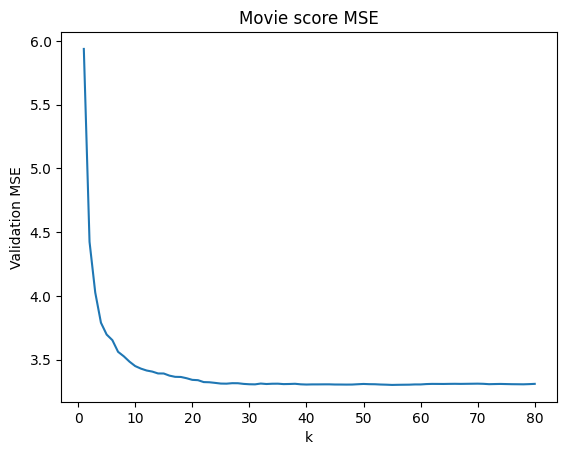

In [112]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

'''
k를 변화시켜가며 더 적합한 k를 찾기 위해 plot을 통해 accuracy를 확인
'''

best_mse = 1000000000
k_list = range(1,81) # k= 1~80까지 조절
mses = []
for k in k_list:
  regressor_k = KNeighborsRegressor(n_neighbors = k, weights="uniform", metric="euclidean")
  regressor_k.fit(x_train, y_train)
  mse = mean_squared_error(y_valid, regressor_k.predict(x_valid))
  mses.append(mse)
  if best_mse > mse:
    best_mse = mse
    best_k = k
plt.plot(k_list, mses)
plt.xlabel("k")
plt.ylabel("Validation MSE")
plt.title("Movie score MSE")
plt.show()

In [113]:
regressor = KNeighborsRegressor(n_neighbors = best_k, weights="uniform", metric="euclidean")

In [114]:
regressor.fit(x_train, y_train)

KNeighborsRegressor(metric='euclidean', n_neighbors=55)

In [115]:
pred_y = regressor.predict(x_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print("MSE :", mean_squared_error(y_test, pred_y))
print("RMSE:", mean_squared_error(y_test, pred_y, squared=False))
print("MAE :", mean_absolute_error(y_test, pred_y))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_y))

MSE : 3.19798787796984
RMSE: 1.788291888358788
MAE : 1.2427050142611504
MAPE: 1419031684154432.0


#### algorithm 선정 - auto

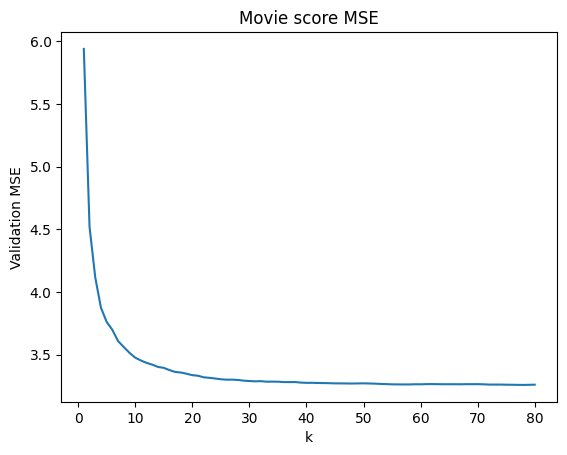

In [117]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

'''
k를 변화시켜가며 더 적합한 k를 찾기 위해 plot을 통해 accuracy를 확인
'''

best_mse = 1000000000
k_list = range(1,81) # k= 1~80까지 조절
mses = []
for k in k_list:
  regressor_k = KNeighborsRegressor(n_neighbors = k, weights="distance", metric="euclidean", algorithm = 'ball_tree')
  regressor_k.fit(x_train, y_train)
  mse = mean_squared_error(y_valid, regressor_k.predict(x_valid))
  mses.append(mse)
  if best_mse > mse:
    best_mse = mse
    best_k = k
plt.plot(k_list, mses)
plt.xlabel("k")
plt.ylabel("Validation MSE")
plt.title("Movie score MSE")
plt.show()

In [118]:
regressor = KNeighborsRegressor(n_neighbors = best_k, weights="distance", metric="euclidean", algorithm = 'ball_tree')

In [119]:
regressor.fit(x_train, y_train)

KNeighborsRegressor(algorithm='ball_tree', metric='euclidean', n_neighbors=78,
                    weights='distance')

In [120]:
pred_y = regressor.predict(x_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print("MSE :", mean_squared_error(y_test, pred_y))
print("RMSE:", mean_squared_error(y_test, pred_y, squared=False))
print("MAE :", mean_absolute_error(y_test, pred_y))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_y))

MSE : 3.1500569117149246
RMSE: 1.7748399679168048
MAE : 1.2320382270448988
MAPE: 1376677374779961.5


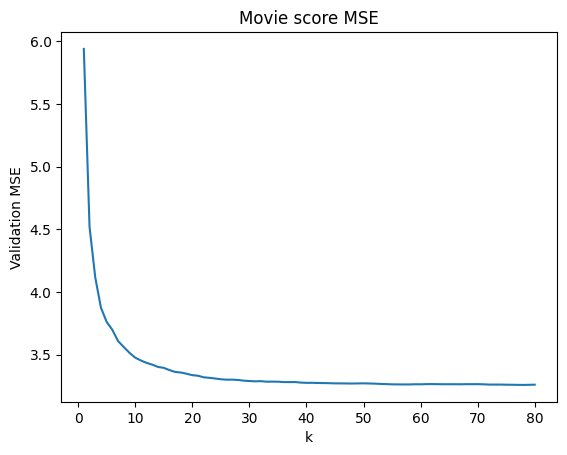

In [121]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

'''
k를 변화시켜가며 더 적합한 k를 찾기 위해 plot을 통해 accuracy를 확인
'''

best_mse = 1000000000
k_list = range(1,81) # k= 1~80까지 조절
mses = []
for k in k_list:
  regressor_k = KNeighborsRegressor(n_neighbors = k, weights="distance", metric="euclidean", algorithm = 'kd_tree')
  regressor_k.fit(x_train, y_train)
  mse = mean_squared_error(y_valid, regressor_k.predict(x_valid))
  mses.append(mse)
  if best_mse > mse:
    best_mse = mse
    best_k = k
plt.plot(k_list, mses)
plt.xlabel("k")
plt.ylabel("Validation MSE")
plt.title("Movie score MSE")
plt.show()

In [122]:
regressor = KNeighborsRegressor(n_neighbors = best_k, weights="distance", metric="euclidean", algorithm = 'kd_tree')

In [123]:
regressor.fit(x_train, y_train)

KNeighborsRegressor(algorithm='kd_tree', metric='euclidean', n_neighbors=78,
                    weights='distance')

In [124]:
pred_y = regressor.predict(x_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print("MSE :", mean_squared_error(y_test, pred_y))
print("RMSE:", mean_squared_error(y_test, pred_y, squared=False))
print("MAE :", mean_absolute_error(y_test, pred_y))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_y))

MSE : 3.1500569117149246
RMSE: 1.7748399679168048
MAE : 1.2320382270448988
MAPE: 1376677374779961.5


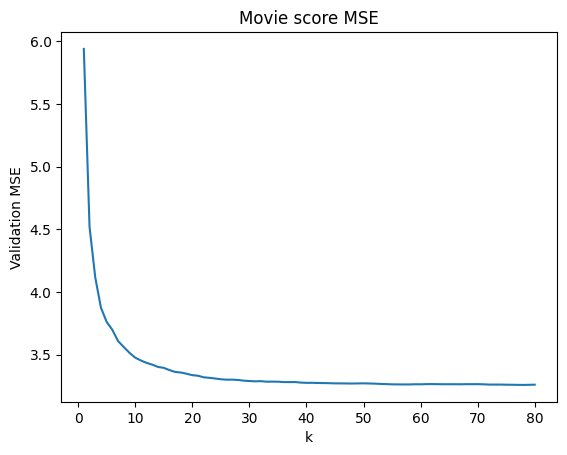

In [125]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

'''
k를 변화시켜가며 더 적합한 k를 찾기 위해 plot을 통해 accuracy를 확인
'''

best_mse = 1000000000
k_list = range(1,81) # k= 1~80까지 조절
mses = []
for k in k_list:
  regressor_k = KNeighborsRegressor(n_neighbors = k, weights="distance", metric="euclidean", algorithm = 'brute')
  regressor_k.fit(x_train, y_train)
  mse = mean_squared_error(y_valid, regressor_k.predict(x_valid))
  mses.append(mse)
  if best_mse > mse:
    best_mse = mse
    best_k = k
plt.plot(k_list, mses)
plt.xlabel("k")
plt.ylabel("Validation MSE")
plt.title("Movie score MSE")
plt.show()

In [126]:
regressor = KNeighborsRegressor(n_neighbors = best_k, weights="distance", metric="euclidean", algorithm = 'brute')

In [127]:
regressor.fit(x_train, y_train)

KNeighborsRegressor(algorithm='brute', metric='euclidean', n_neighbors=78,
                    weights='distance')

In [128]:
pred_y = regressor.predict(x_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print("MSE :", mean_squared_error(y_test, pred_y))
print("RMSE:", mean_squared_error(y_test, pred_y, squared=False))
print("MAE :", mean_absolute_error(y_test, pred_y))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_y))

MSE : 3.150056911715222
RMSE: 1.7748399679168887
MAE : 1.2320382266300756
MAPE: 1376677372093307.5


#### metric 선정 - manhattan

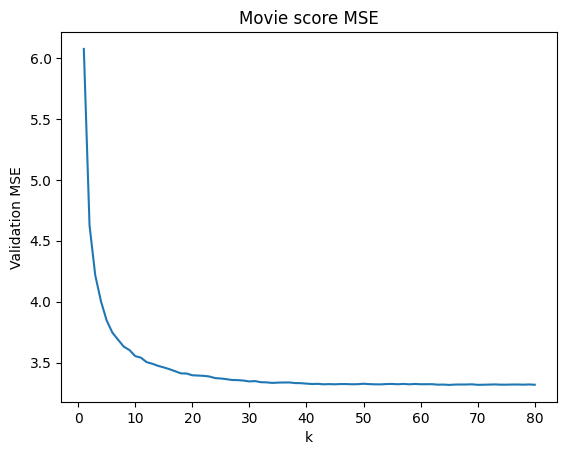

In [129]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

'''
k를 변화시켜가며 더 적합한 k를 찾기 위해 plot을 통해 accuracy를 확인
'''

best_mse = 1000000000
k_list = range(1,81) # k= 1~80까지 조절
mses = []
for k in k_list:
  regressor_k = KNeighborsRegressor(n_neighbors = k, weights="distance", metric="chebyshev")
  regressor_k.fit(x_train, y_train)
  mse = mean_squared_error(y_valid, regressor_k.predict(x_valid))
  mses.append(mse)
  if best_mse > mse:
    best_mse = mse
    best_k = k
plt.plot(k_list, mses)
plt.xlabel("k")
plt.ylabel("Validation MSE")
plt.title("Movie score MSE")
plt.show()

In [130]:
regressor = KNeighborsRegressor(n_neighbors = best_k, weights="distance", metric="chebyshev")

In [131]:
regressor.fit(x_train, y_train)

KNeighborsRegressor(metric='chebyshev', n_neighbors=65, weights='distance')

In [132]:
pred_y = regressor.predict(x_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print("MSE :", mean_squared_error(y_test, pred_y))
print("RMSE:", mean_squared_error(y_test, pred_y, squared=False))
print("MAE :", mean_absolute_error(y_test, pred_y))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_y))

MSE : 3.1997020942971712
RMSE: 1.7887711128864898
MAE : 1.2398204562510542
MAPE: 1393596678427029.0


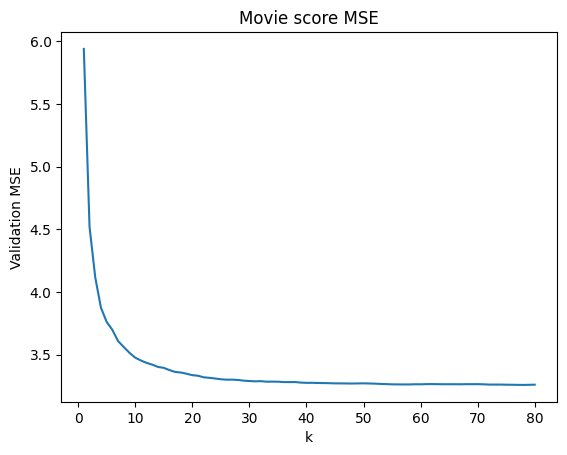

In [133]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

'''
k를 변화시켜가며 더 적합한 k를 찾기 위해 plot을 통해 accuracy를 확인
'''

best_mse = 1000000000
k_list = range(1,81) # k= 1~80까지 조절
mses = []
for k in k_list:
  regressor_k = KNeighborsRegressor(n_neighbors = k, weights="distance", metric="minkowski")
  regressor_k.fit(x_train, y_train)
  mse = mean_squared_error(y_valid, regressor_k.predict(x_valid))
  mses.append(mse)
  if best_mse > mse:
    best_mse = mse
    best_k = k
plt.plot(k_list, mses)
plt.xlabel("k")
plt.ylabel("Validation MSE")
plt.title("Movie score MSE")
plt.show()

In [134]:
regressor = KNeighborsRegressor(n_neighbors = best_k, weights="distance", metric="minkowski")

In [135]:
regressor.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=78, weights='distance')

In [136]:
pred_y = regressor.predict(x_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print("MSE :", mean_squared_error(y_test, pred_y))
print("RMSE:", mean_squared_error(y_test, pred_y, squared=False))
print("MAE :", mean_absolute_error(y_test, pred_y))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_y))

MSE : 3.1500569117149246
RMSE: 1.7748399679168048
MAE : 1.2320382270448988
MAPE: 1376677374779961.5


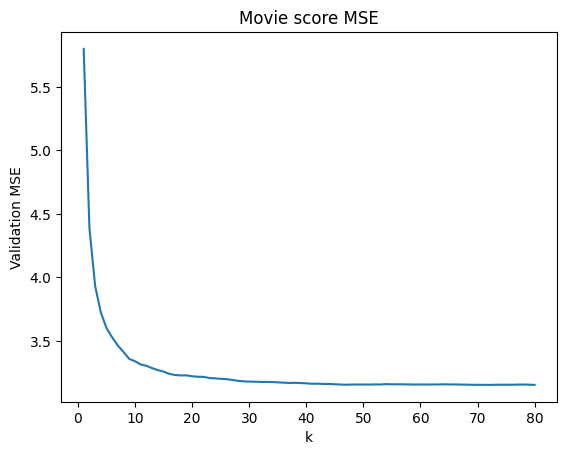

In [137]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

'''
k를 변화시켜가며 더 적합한 k를 찾기 위해 plot을 통해 accuracy를 확인
'''

best_mse = 1000000000
k_list = range(1,81) # k= 1~80까지 조절
mses = []
for k in k_list:
  regressor_k = KNeighborsRegressor(n_neighbors = k, weights="distance", metric="manhattan")
  regressor_k.fit(x_train, y_train)
  mse = mean_squared_error(y_valid, regressor_k.predict(x_valid))
  mses.append(mse)
  if best_mse > mse:
    best_mse = mse
    best_k = k
plt.plot(k_list, mses)
plt.xlabel("k")
plt.ylabel("Validation MSE")
plt.title("Movie score MSE")
plt.show()

In [138]:
regressor = KNeighborsRegressor(n_neighbors = best_k, weights="distance", metric="manhattan")

In [139]:
regressor.fit(x_train, y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=72, weights='distance')

In [140]:
pred_y = regressor.predict(x_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print("MSE :", mean_squared_error(y_test, pred_y))
print("RMSE:", mean_squared_error(y_test, pred_y, squared=False))
print("MAE :", mean_absolute_error(y_test, pred_y))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_y))

MSE : 3.0543789404181876
RMSE: 1.7476781569894921
MAE : 1.2219950111848765
MAPE: 1323497180607568.0


### Step 4. Evaluation

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html

y_true = 0인 케이스 때문에 MAPE 값이 매우 크게 나타난다. 
그러나 다른 값들은 정상적으로 나타난다. (scikit-learn 설명 참조)

In [141]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print("MSE :", mean_squared_error(y_test, pred_y))
print("RMSE:", mean_squared_error(y_test, pred_y, squared=False))
print("MAE :", mean_absolute_error(y_test, pred_y))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_y))

MSE : 3.0543789404181876
RMSE: 1.7476781569894921
MAE : 1.2219950111848765
MAPE: 1323497180607568.0


# AR (Association Rules; 연관규칙)

## Step 1. Import the necessary libraries

In [142]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

## Step 2. Import the dataset

In [143]:
ratings_df = pd.read_csv(f"{ROOT}/ratings_small.csv")

In [144]:
print(ratings_df.shape)
ratings_df.head()

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [145]:
movies_df = pd.read_csv(f"{ROOT}/movies_metadata.csv")

<ipython-input-145-194477f411f5>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df = pd.read_csv(f"{ROOT}/movies_metadata.csv")


In [146]:
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [147]:
movies_df.drop(movies_df.index[19730],inplace=True)
movies_df.drop(movies_df.index[29502],inplace=True)
movies_df.drop(movies_df.index[35585],inplace=True)

In [148]:
movies_df.id = movies_df.id.astype(np.int64)

In [149]:
ratings_df.movieId.isin(movies_df.id).sum()

44989

In [150]:
ratings_df = pd.merge(ratings_df,movies_df[['title','id']],left_on='movieId',right_on='id')
print(ratings_df.shape)
ratings_df.head()

(44994, 6)


,userId,movieId,rating,timestamp,title,id
0,1,1371,2.5,1260759135,Rocky III,1371
1,4,1371,4.0,949810302,Rocky III,1371
2,7,1371,3.0,851869160,Rocky III,1371
3,19,1371,4.0,855193404,Rocky III,1371
4,21,1371,3.0,853852263,Rocky III,1371


In [151]:
ratings_df.drop(['timestamp','id'],axis=1,inplace=True)
print(ratings_df.shape)
ratings_df.head(5)

(44994, 4)


,userId,movieId,rating,title
0,1,1371,2.5,Rocky III
1,4,1371,4.0,Rocky III
2,7,1371,3.0,Rocky III
3,19,1371,4.0,Rocky III
4,21,1371,3.0,Rocky III


In [152]:
ratings_df.sample(5)

,userId,movieId,rating,title
34758,311,954,2.5,Mission: Impossible
42919,205,98491,5.0,Wuthering Heights
19731,462,2302,4.0,Avalon
40640,652,1586,3.5,Secret Window
29939,525,3489,3.0,88 Minutes


In [153]:
ratings_df.isnull().sum()

userId     0
movieId    0
rating     0
title      0
dtype: int64

In [154]:
len(ratings_df['title'].unique())

2794

In [155]:
ratings_count = ratings_df.groupby(by="title")['rating'].count().reset_index().rename(columns={'rating':'totalRatings'})[['title','totalRatings']]


In [156]:
print(ratings_count.shape)
ratings_count.sort_values(by = 'totalRatings', ascending = False).head()

(2794, 2)


,title,totalRatings
1959,Terminator 3: Rise of the Machines,324
2306,The Million Dollar Hotel,311
1837,Solaris,305
1967,The 39 Steps,291
1374,Monsoon Wedding,274


In [157]:
ratings_total = pd.merge(ratings_df,ratings_count,on='title',how='left')
print(ratings_total.shape)
ratings_total.head()

(44994, 5)


,userId,movieId,rating,title,totalRatings
0,1,1371,2.5,Rocky III,47
1,4,1371,4.0,Rocky III,47
2,7,1371,3.0,Rocky III,47
3,19,1371,4.0,Rocky III,47
4,21,1371,3.0,Rocky III,47


In [158]:
ratings_count['totalRatings'].describe()

count    2794.000000
mean       16.103794
std        31.481306
min         1.000000
25%         1.000000
50%         4.000000
75%        15.750000
max       324.000000
Name: totalRatings, dtype: float64

In [159]:
ratings_count['totalRatings'].quantile(np.arange(.6,1,0.01))

0.60      7.00
0.61      7.00
0.62      7.00
0.63      8.00
0.64      8.00
0.65      9.00
0.66      9.00
0.67     10.00
0.68     10.00
0.69     11.00
0.70     12.00
0.71     12.00
0.72     13.00
0.73     14.00
0.74     14.00
0.75     15.75
0.76     17.00
0.77     18.00
0.78     19.00
0.79     20.00
0.80     21.00
0.81     22.33
0.82     24.00
0.83     26.00
0.84     27.00
0.85     29.00
0.86     31.00
0.87     34.00
0.88     37.00
0.89     41.77
0.90     45.00
0.91     49.00
0.92     52.56
0.93     59.00
0.94     64.42
0.95     71.00
0.96     83.28
0.97     98.21
0.98    119.14
0.99    168.49
Name: totalRatings, dtype: float64

In [160]:
votes_count_threshold = 30
ratings_top = ratings_total.query('totalRatings > @votes_count_threshold')
print(ratings_top.shape)
ratings_top.head()

(30169, 5)


,userId,movieId,rating,title,totalRatings
0,1,1371,2.5,Rocky III,47
1,4,1371,4.0,Rocky III,47
2,7,1371,3.0,Rocky III,47
3,19,1371,4.0,Rocky III,47
4,21,1371,3.0,Rocky III,47


In [161]:
len(ratings_top['title'].unique())

403

In [162]:
if not ratings_top[ratings_top.duplicated(['userId','title'])].empty:
    ratings_top = ratings_top.drop_duplicates(['userId','title'])
ratings_top.shape

(30030, 5)

In [163]:
df_for_knn = ratings_top.pivot(index='title',columns='userId',values='rating').fillna(0)
print(df_for_knn.shape)
df_for_knn.head()

(403, 670)


userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
"20,000 Leagues Under the Sea",0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001: A Space Odyssey,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
28 Weeks Later,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48 Hrs.,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,3.0,0.0


In [164]:
def encode_units(x):
    if x<=0:
        return 0
    if x>=1:
        return 1

In [165]:
df_for_ar = df_for_knn.T.applymap(encode_units)
print(df_for_ar.shape)
df_for_ar.head()

(670, 403)


title,"20,000 Leagues Under the Sea",2001: A Space Odyssey,28 Weeks Later,300,48 Hrs.,5 Card Stud,7 Virgins,8 Women,88 Minutes,A Bridge Too Far,...,Will Penny,Willy Wonka & the Chocolate Factory,Windows on Monday,Wish You Were Here,X-Men Origins: Wolverine,Y Tu Mamá También,Yesterday,Young Adam,Young and Innocent,Zatoichi
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0,0.0,0,0,0.0,0,0,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
2,0.0,1,0.0,0,1,0.0,0,0,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
3,0.0,0,0.0,1,0,0.0,0,0,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0
4,1.0,0,0.0,0,0,0.0,0,0,0,0.0,...,0.0,0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0
5,0.0,0,0.0,0,1,0.0,0,0,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0


In [166]:
df_for_ar = df_for_ar.astype(bool)
df_for_ar.head()

title,"20,000 Leagues Under the Sea",2001: A Space Odyssey,28 Weeks Later,300,48 Hrs.,5 Card Stud,7 Virgins,8 Women,88 Minutes,A Bridge Too Far,...,Will Penny,Willy Wonka & the Chocolate Factory,Windows on Monday,Wish You Were Here,X-Men Origins: Wolverine,Y Tu Mamá También,Yesterday,Young Adam,Young and Innocent,Zatoichi
userId,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
5,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


## Step 3. Preprocess the dataset to appropriate form for association rule mining
- `mlxtend`에서 제공하는 [`TransactionEncoder`](http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/)을 사용하여 list 형식으로 구성된 거래 데이터를 2차원 numpy array로 변경  

In [167]:
# 이미 True / False 값으로 변경했기 때문에 실행하지 않아도 됨

## Step 4. Association rule mining

In [168]:
''' Apriori Algorithm 활용
- 빈번하게 발생하는 아이템 셋에 대해서만 계산 (minimum support를 넘지 못하는 아이템을 포함하는 모든 아이템셋은 minimum support를 넘지 못함)
1. Support
- Minimum support를 지정하여, 등장 횟수가 일정 비율 이상의 아이템 set만 선정
  - 1) 각 item들에 대해 지지도를 계산 후 minimum 지지도가 넘는 items를 선정
  - 2) 1에서 구한 items들의 2개 조합으로 구성한 set을 생성 후 지지도 계산 (minimum 이상)
  - 3) 2에서 구한 set들의 조합으로, 3개의 item으로 구성된 항목에 대해 지지도 계산
  - 4) minimum 값을 넘는 조합이 없을 때까지 조합에 포함되는 item 개수를 늘려줌
'''
frequent_itemsets = apriori(df_for_ar, min_support=0.1, use_colnames=True) # 여기서는 0.1를 기준으로 선정
frequent_itemsets.sort_values(by='support', ascending=False)

,support,itemsets
112,0.483582,(Terminator 3: Rise of the Machines)
131,0.464179,(The Million Dollar Hotel)
106,0.455224,(Solaris)
114,0.434328,(The 39 Steps)
70,0.408955,(Monsoon Wedding)
...,...,...
4651,0.100000,"(Syriana, 48 Hrs., Rain Man, Sissi)"
4648,0.100000,"(Silent Hill, Three Colors: Red, 48 Hrs., Rain..."
383,0.100000,"(Arlington Road, Reservoir Dogs)"
4647,0.100000,"(Silent Hill, 48 Hrs., Rain Man, The Million D..."


In [169]:
frequent_itemsets.sort_values(by = 'support', ascending = False)[:20]

,support,itemsets
112,0.483582,(Terminator 3: Rise of the Machines)
131,0.464179,(The Million Dollar Hotel)
106,0.455224,(Solaris)
114,0.434328,(The 39 Steps)
70,0.408955,(Monsoon Wedding)
83,0.364179,(Once Were Warriors)
144,0.340299,(Three Colors: Red)
66,0.334328,(Men in Black II)
1209,0.334328,"(Terminator 3: Rise of the Machines, Solaris)"
1256,0.326866,"(Terminator 3: Rise of the Machines, The Milli..."


가장 많은 평점이 남겨진 영화는 'Terminator 3: Rise of the Machines' (support = 0.483582), 'The Million Dollar Hotel' (0.464179), 'Solaris' (0.455224) 등이 있다.

'Solaris', 'Terminator 3: Rise of the Machines' 에 같이 평점을 남긴 경우가 많다. (support = 0.334328)

In [170]:
'''
2. Confidence
- 앞서 선정한 items (많이 구매된 메뉴)을 사용하여 함께 구매된 items를 확인
- antecedents (조건절), consequents (결과절): Antecedents를 구매했을 때 consequents를 구매
'''
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2).sort_values(by = ['confidence', 'lift', 'support'], ascending=False) # 최소 confidence를 0.1로 지정

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
23934,"(Romeo + Juliet, 48 Hrs., Rain Man)",(Sissi),0.104478,0.317910,0.104478,1.000000,3.145540,0.071263,inf
20745,"(48 Hrs., Rain Man, A Nightmare on Elm Street)",(Monsoon Wedding),0.126866,0.408955,0.125373,0.988235,2.416488,0.073491,50.238806
60675,"(48 Hrs., Rain Man, A Nightmare on Elm Street,...",(Monsoon Wedding),0.116418,0.408955,0.114925,0.987179,2.413906,0.067316,46.101493
60736,"(Terminator 3: Rise of the Machines, 48 Hrs., ...",(Monsoon Wedding),0.110448,0.408955,0.108955,0.986486,2.412211,0.063787,43.737313
20675,"(48 Hrs., Back to the Future Part II, A Nightm...",(Monsoon Wedding),0.107463,0.408955,0.105970,0.986111,2.411294,0.062023,42.555224
...,...,...,...,...,...,...,...,...,...
15623,(Terminator 3: Rise of the Machines),"(The Million Dollar Hotel, My Name Is Bruce)",0.483582,0.128358,0.100000,0.206790,1.611039,0.037928,1.098879
4433,(Terminator 3: Rise of the Machines),"(The Passion of Joan of Arc, 5 Card Stud)",0.483582,0.129851,0.100000,0.206790,1.592522,0.037207,1.096998
11808,(Terminator 3: Rise of the Machines),"(Dawn of the Dead, Rope)",0.483582,0.131343,0.100000,0.206790,1.574425,0.036485,1.095116
12227,(Terminator 3: Rise of the Machines),"(The Passion of Joan of Arc, Grill Point)",0.483582,0.131343,0.100000,0.206790,1.574425,0.036485,1.095116


- (Rain Man, Romeo + Juliet, 48 Hrs.)와 (Sissi)은 confidence가 1로, 두 집합에 속한 사용자가 완전히 동일하다.
- (Rain Man, 48 Hrs., A Nightmare on Elm Street)에 평점을 남긴 사용자는 거의 모두 (Monsoon Wedding)에도 평점을 남겼다. (confidence = 0.988235)


In [171]:
'''
3. Lift
- 1보다 클 경우 A를 샀을 때 B을 살 확률이 높아지는 것을 의미
- 1보다 작을 경우 A를 샀을 때 B을 사지 않을 확률이 높은 것을 의미  
'''
association_rules(frequent_itemsets, metric="lift", min_threshold=3).sort_values(by = [ 'lift', 'confidence', 'support'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
53,(Waiter),(Muxmäuschenstill),0.120896,0.156716,0.105970,0.876543,5.593180,0.087024,6.830597
52,(Muxmäuschenstill),(Waiter),0.156716,0.120896,0.105970,0.676190,5.593180,0.087024,2.714881
7785,"(Psycho, Solaris)","(Terminator 3: Rise of the Machines, Big Fish)",0.134328,0.143284,0.100000,0.744444,5.195602,0.080753,3.352369
7786,"(Terminator 3: Rise of the Machines, Big Fish)","(Psycho, Solaris)",0.143284,0.134328,0.100000,0.697917,5.195602,0.080753,2.865672
7764,"(Psycho, Rain Man)","(Big Fish, Titanic)",0.131343,0.150746,0.101493,0.772727,5.126013,0.081693,3.736716
...,...,...,...,...,...,...,...,...,...
12249,"(Monsoon Wedding, Solaris, Rain Man)","(48 Hrs., The Million Dollar Hotel)",0.177612,0.204478,0.108955,0.613445,3.000061,0.072638,2.057982
20074,"(Silent Hill, Monsoon Wedding, Terminator 3: R...","(The Conversation, Sissi)",0.177612,0.204478,0.108955,0.613445,3.000061,0.072638,2.057982
12256,"(48 Hrs., The Million Dollar Hotel)","(Monsoon Wedding, Solaris, Rain Man)",0.204478,0.177612,0.108955,0.532847,3.000061,0.072638,1.760424
20075,"(The Conversation, Sissi)","(Silent Hill, Monsoon Wedding, Terminator 3: R...",0.204478,0.177612,0.108955,0.532847,3.000061,0.072638,1.760424


(Waiter)에 평점을 남긴 사용자가 (Muxmäuschenstill)에 평점을 남길 확률에는 양의 상관관계가 있으며, 그 역도 성립함 (lift = 5.593180, 양방향 모두 동일)

- 지지도, 신뢰도 등의 minimum threshold를 결정할 때 주관성이 들어갈 수 있음
- 목적에 따라 중요하게 판단할 기준이 다를 수 있음
  - 신뢰도가 동일하다고 했을 때, 소비자노출이 중요하다면 지지도가 높은 Rule이, 노출 대비 소비자 반응률(구매여부)이 중요한 경우 향상도가 높은 Rule이 더 좋은 규칙

# Collaborative Filtering (협업 필터링) : User-based

## Step1. Movie metadata, rating, link 데이터를 불러온 후 결합

In [172]:
ratings = pd.read_csv(f"{ROOT}/ratings_small.csv")

In [173]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [174]:
metadata = pd.read_csv(f"{ROOT}/movies_metadata.csv", parse_dates=True)
metadata.head()

<ipython-input-174-73d0aa9debcf>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{ROOT}/movies_metadata.csv", parse_dates=True)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [175]:
links = pd.read_csv(f"{ROOT}/links_small.csv")
links.dropna(inplace=True)
links.tmdbId = links.tmdbId.map(int)
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862
1,2,113497,8844
2,3,113228,15602
3,4,114885,31357
4,5,113041,11862


In [176]:
df = metadata[['genres', 'id', 'imdb_id', 'overview', 'release_date', 'title']]
df.dropna(inplace=True)
df.imdb_id = df.imdb_id.str.replace('tt', '')
df.imdb_id = df.imdb_id.map(int)
df.id = df.id.map(int)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44423 entries, 0 to 45465
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   genres        44423 non-null  object
 1   id            44423 non-null  int64 
 2   imdb_id       44423 non-null  int64 
 3   overview      44423 non-null  object
 4   release_date  44423 non-null  object
 5   title         44423 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB
None


<ipython-input-176-6461a19e5996>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
<ipython-input-176-6461a19e5996>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.imdb_id = df.imdb_id.str.replace('tt', '')
<ipython-input-176-6461a19e5996>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.imdb_i

,genres,id,imdb_id,overview,release_date,title
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,114709,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,Toy Story
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,113497,When siblings Judy and Peter discover an encha...,1995-12-15,Jumanji
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,113228,A family wedding reignites the ancient feud be...,1995-12-22,Grumpier Old Men
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,114885,"Cheated on, mistreated and stepped on, the wom...",1995-12-22,Waiting to Exhale
4,"[{'id': 35, 'name': 'Comedy'}]",11862,113041,Just when George Banks has recovered from his ...,1995-02-10,Father of the Bride Part II


In [177]:
data = ratings.set_index('movieId').join(links.set_index('movieId')).reset_index().set_index('tmdbId').join(df.set_index('id')).dropna()
data = data.reset_index(drop=True)
data.drop(columns=['imdb_id'], inplace=True)
data.sample(6)

,movieId,userId,rating,timestamp,imdbId,genres,overview,release_date,title
76282,3484,102,1.0,957893428,192614.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",Luke's exultance at being selected for The Sku...,2000-03-31,The Skulls
31191,2028,311,5.0,930668230,120815.0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...","As U.S. troops storm the beaches of Normandy, ...",1998-07-24,Saving Private Ryan
16057,1028,358,4.0,957480496,58331.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...","The movie combines a diverting story, songs, c...",1964-08-27,Mary Poppins
83745,108795,652,4.0,1442082700,1186373.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","On the mystical island of Themyscira, a proud ...",2009-03-03,Wonder Woman
31272,2028,578,0.5,1418984418,120815.0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...","As U.S. troops storm the beaches of Normandy, ...",1998-07-24,Saving Private Ryan
13222,6870,15,3.5,1068955127,327056.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...","A story about friendship and loyalty, guilt an...",2003-10-07,Mystic River


In [178]:
df = metadata[['genres', 'id', 'imdb_id', 'overview', 'release_date', 'title']]
df.dropna(inplace=True)
df.imdb_id = df.imdb_id.str.replace('tt', '')
df.imdb_id = df.imdb_id.map(int)
df.id = df.id.map(int)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44423 entries, 0 to 45465
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   genres        44423 non-null  object
 1   id            44423 non-null  int64 
 2   imdb_id       44423 non-null  int64 
 3   overview      44423 non-null  object
 4   release_date  44423 non-null  object
 5   title         44423 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB
None


<ipython-input-178-6461a19e5996>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
<ipython-input-178-6461a19e5996>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.imdb_id = df.imdb_id.str.replace('tt', '')
<ipython-input-178-6461a19e5996>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.imdb_i

,genres,id,imdb_id,overview,release_date,title
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,114709,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,Toy Story
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,113497,When siblings Judy and Peter discover an encha...,1995-12-15,Jumanji
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,113228,A family wedding reignites the ancient feud be...,1995-12-22,Grumpier Old Men
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,114885,"Cheated on, mistreated and stepped on, the wom...",1995-12-22,Waiting to Exhale
4,"[{'id': 35, 'name': 'Comedy'}]",11862,113041,Just when George Banks has recovered from his ...,1995-02-10,Father of the Bride Part II


In [179]:
data = ratings.set_index('movieId').join(links.set_index('movieId')).reset_index().set_index('tmdbId').join(df.set_index('id')).dropna()
data = data.reset_index(drop=True)
data.drop(columns=['imdb_id'], inplace=True)
data.sample(6)

,movieId,userId,rating,timestamp,imdbId,genres,overview,release_date,title
44517,1197,247,4.0,953271023,93779.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751...","In this enchantingly cracked fairy tale, the b...",1987-09-18,The Princess Bride
39536,3325,564,4.0,974838545,156841.0,"[{'id': 35, 'name': 'Comedy'}]",A comedy-drama about best friends - one a stra...,2000-03-03,The Next Best Thing
8208,44665,423,3.5,1356121024,425210.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",Slevin is mistakenly put in the middle of a pe...,2006-02-24,Lucky Number Slevin
27164,44191,664,4.5,1343746853,434409.0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",In a world in which Great Britain has become a...,2006-03-15,V for Vendetta
68047,2094,4,4.0,949920028,102803.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",Straight from the pages of a pulp comic from a...,1991-06-21,The Rocketeer
53804,2278,574,4.5,1232812237,122690.0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",A briefcase with undisclosed contents – sought...,1998-09-25,Ronin


## Step2. Filtered_items라는 함수를 사용하여 특정 등급 미만의 영화 및 사용자를 필터링

In [180]:
def filtered_items(n, f, group, series, df):
    stats = df.groupby(group)[series].agg(f)
    stats.index = stats.index.map(int)
    benchmark = round(stats['count'].quantile(n), 0)
    rm_items_index = stats[stats['count'] < benchmark].index
    return rm_items_index
drop_m_ind = filtered_items(n=0.7, f=['count', 'mean'], group='movieId', series='rating', df=ratings)
drop_u_ind = filtered_items(n=0.7, f=['count', 'mean'], group='userId', series='rating', df=ratings)

ratings_filtered = ratings[~ratings.movieId.isin(drop_m_ind)]
ratings_filtered = ratings_filtered[~ratings_filtered.userId.isin(drop_u_ind)].drop('timestamp', axis=1)

In [181]:
ratings_filtered

,userId,movieId,rating
147,4,10,4.0
148,4,34,5.0
149,4,112,5.0
150,4,141,5.0
151,4,153,4.0
...,...,...,...
99686,665,5479,2.0
99688,665,5502,4.0
99689,665,5679,3.0
99690,665,5952,5.0


In [182]:
movies_link = data[['movieId', 'title', 'genres']].drop_duplicates(['movieId', 'title', 'genres']).set_index('movieId')
movies_link.head()

,title,genres
movieId,,
4470,Ariel,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name..."
18,Four Rooms,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name..."
479,Judgment Night,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam..."
260,Star Wars,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '..."
6377,Finding Nemo,"[{'id': 16, 'name': 'Animation'}, {'id': 10751..."


## Step3. 사용자를 행으로, 영화를 열로 사용하여 등급 피벗 테이블 제작

In [183]:
m = ratings_filtered.pivot_table(index='userId', columns='movieId', values='rating')
user_m = m.fillna(0)
movie_m = user_m.T
m.head()

movieId,1,2,3,4,5,6,7,9,10,11,...,132046,134130,134853,136864,138036,139385,139644,142488,148626,152081
userId,,,,,,,,,,,,,,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,2.0,2.0,NaN,NaN,4.5,4.0,NaN,NaN,3.0,2.5,...,0.5,3.5,1.0,3.0,1.0,2.5,3.0,3.5,3.5,3.0
17,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,3.0,3.0,3.0,3.0,NaN,3.0,3.0,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step4. 코사인 유사도를 사용하여 user - based collaborative filtering

In [184]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def cosine_re_userBased(n, userId):
    
    cosine_user_m = cosine_similarity(user_m) - np.eye(user_m.shape[0])
    
    sim_index_user = np.argsort(cosine_user_m[userId-1])[::-1]
    sim_score_user = np.sort(cosine_user_m[userId-1])[::-1]
    
    urated_movies = m.loc[userId,][m.loc[userId,].isna()].index
    
    mean_mov_re = (user_m.iloc[sim_index_user[:50]].T * sim_score_user[:50]).T.mean(axis=0)
    
    top_recommendation = mean_mov_re[urated_movies].sort_values(ascending=False)[:n].to_frame().join(movies_link[['title']])
    
    print(top_recommendation)

In [185]:
cosine_re_userBased(n=20, userId=119)

                0                                              title
movieId                                                             
1222     0.770829                                  Full Metal Jacket
2959     0.761705                                         Fight Club
1307     0.726349                            When Harry Met Sally...
2791     0.724587                                          Airplane!
2396     0.698609                                Shakespeare in Love
1288     0.684089                                 This Is Spinal Tap
4993     0.682841  The Lord of the Rings: The Fellowship of the Ring
1500     0.673632                                Grosse Pointe Blank
150      0.659549                                          Apollo 13
380      0.650902                                          True Lies
293      0.633143                             Leon: The Professional
4027     0.630034                         O Brother, Where Art Thou?
5952     0.625285              The